In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/alpha_delta/*.csv'
dic_files = Load_files.load_files(path, -18, -16)
data = dic_files['대구']
data

,stdDay,incDec,alpha_variants,delta_variants
0,2021-04-12,16.0,4.16,0.32
1,2021-04-13,9.0,2.34,0.18
2,2021-04-14,11.0,2.86,0.22
3,2021-04-15,18.0,4.68,0.36
4,2021-04-16,4.0,1.04,0.08
...,...,...,...,...
121,2021-08-11,66.0,0.66,62.70
122,2021-08-12,39.0,0.39,37.05
123,2021-08-13,57.0,0.57,54.15
124,2021-08-14,82.0,0.82,77.90


In [3]:
learning_rates_list = [1e-3, 1e-4, 1e-5]
patiences_list = [20, 50]
num_layers_list = [1, 2, 4, 8]
batch_sizes_list = [32, 64]
hidden_sizes_list = [8, 16, 32]
dropout_list = [0.25]

hyperparameter_dict = {}
i = 0

for lr in learning_rates_list:
    for patience in patiences_list:
        for num_layers in num_layers_list:
            for batch_sizes in batch_sizes_list:
                for hidden_size in hidden_sizes_list:    
                    for dropout in dropout_list:
                        hyperparameter_dict[i] = [lr, patience, num_layers, batch_sizes, hidden_size, dropout]
                        i += 1
                        
print(i)

144


In [4]:
criterion = nn.MSELoss()

input_size = 3
sequence_length = 60
num_epochs = 10000

df = Prepare_df.processing(data, 'stdDay', 'delta_variants')

x = df.iloc[:, 0:]
y = df.iloc[:,:1]

ms = MinMaxScaler()
ss = StandardScaler()

ss.fit(x)
ms.fit(y)

rmse_min = np.inf
best_model = {}

for hyperparameter in tqdm(hyperparameter_dict.values(), desc = '대구_GRU', position = 0):
    lr = hyperparameter[0]
    patience = hyperparameter[1]
    num_layers = hyperparameter[2]
    batch_size = hyperparameter[3]
    hidden_size = hyperparameter[4]
    dropout = hyperparameter[5]
    print('-------------------------------------------------------------------------------------')
    print('lr:', lr, ' patience:', patience, ' num_layers:', num_layers, 
          ' batch_size:', batch_size, ' hidden_size:', hidden_size, ' dropout:', dropout)
    
    x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 59, 60, 1, batch_size, 'mto')
    

    model = GRU(input_size = input_size,
                 hidden_size = hidden_size,
                 sequence_length = sequence_length,
                 num_layers = num_layers, 
                 dropout = dropout, 
                 device = device).to(device)

    optimizer = Adam(model.parameters(), lr = lr)
    
    loss_list, model, epoch = Trainer.Many_to_One(train_loader, 
                                                  test_loader, 
                                                  model, 
                                                  criterion, 
                                                  optimizer, 
                                                  num_epochs, 
                                                  patience,
                                                  device)
    
    label_y, predicted = predict_mto(model, df, x_ss, y_ms)
    
    if rmse_min > rmse(label_y[-7:], predicted[-7:]):
        rmse_min = rmse(label_y[-7:], predicted[-7:])
        best_model['GRU'] = [rmse_min, model, loss_list, epoch, lr, patience, 
                             num_layers, batch_size, hidden_size, dropout]

대구_GRU:   0%|          | 0/144 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 187 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 146 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 173 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 536 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 367 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 445 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 130 loss: 0.0050
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 112 loss: 0.0022
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 129 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 210 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0011
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 175 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 25 loss: 0.0502
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.0028
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 182 loss: 0.0022
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 141 loss: 0.0105
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.0119
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 154 loss: 0.0064
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0537
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 26 loss: 0.0517
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 247 loss: 0.0035
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 38 loss: 0.0501
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 84 loss: 0.0103
-------------------------------------------------------------------------------------
lr: 0.001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 231 loss: 0.0047
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 529 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 896 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 354 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1347 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 800 loss: 0.0001
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 503 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 428 loss: 0.0006
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 433 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 356 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 544 loss: 0.0008
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 440 loss: 0.0007
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 410 loss: 0.0002
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 426 loss: 0.0020
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 259 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 455 loss: 0.0005
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 413 loss: 0.0034
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 463 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 509 loss: 0.0003
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 54 loss: 0.0523
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 349 loss: 0.0022
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 480 loss: 0.0012
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 437 loss: 0.0044
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 559 loss: 0.0018
-------------------------------------------------------------------------------------
lr: 0.001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 370 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1363 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1058 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1138 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2875 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2789 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2557 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 153 loss: 0.0082
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 177 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 355 loss: 0.0024
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 188 loss: 0.0102
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 142 loss: 0.0102
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 327 loss: 0.0022
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 216 loss: 0.0173
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 152 loss: 0.0152
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 110 loss: 0.0134
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 191 loss: 0.0146
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 156 loss: 0.0119
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 136 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 39 loss: 0.0523
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 44 loss: 0.0524
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 31 loss: 0.0524
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 88 loss: 0.0499
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 113 loss: 0.0500
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 59 loss: 0.0504
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1881 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1559 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2421 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 3984 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2019 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 2860 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 230 loss: 0.0113
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 733 loss: 0.0017
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 685 loss: 0.0010
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 697 loss: 0.0025
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 660 loss: 0.0026
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 542 loss: 0.0013
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 298 loss: 0.0132
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 247 loss: 0.0151
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 197 loss: 0.0125
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 311 loss: 0.0148
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 293 loss: 0.0132
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 340 loss: 0.0099
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 165 loss: 0.0519
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 575 loss: 0.0065
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 64 loss: 0.0522
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 115 loss: 0.0505
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 336 loss: 0.0103
-------------------------------------------------------------------------------------
lr: 0.0001  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 303 loss: 0.0118
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 6578 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 5611 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 5430 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 604 loss: 0.0160
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 462 loss: 0.0135
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 436 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 528 loss: 0.0317
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 756 loss: 0.0112
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 421 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 192 loss: 0.0524
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 286 loss: 0.0494
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 209 loss: 0.0494
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 133 loss: 0.0490
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 267 loss: 0.0501
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 167 loss: 0.0490
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 173 loss: 0.0524
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 148 loss: 0.0528
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 211 loss: 0.0522
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 277 loss: 0.0498
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 94 loss: 0.0507
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 20  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 93 loss: 0.0502
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 8456 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 7975 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 6709 loss: 0.0000
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 1  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]

-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1087 loss: 0.0108
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 847 loss: 0.0114
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 457 loss: 0.0110
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 972 loss: 0.0107
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 714 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 2  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 888 loss: 0.0093
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 233 loss: 0.0513
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 1262 loss: 0.0151
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 830 loss: 0.0126
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 296 loss: 0.0504
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 900 loss: 0.0138
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 4  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 966 loss: 0.0123
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 221 loss: 0.0520
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 307 loss: 0.0523
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 32  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 201 loss: 0.0520
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 8  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 285 loss: 0.0502
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 16  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 167 loss: 0.0494
-------------------------------------------------------------------------------------
lr: 1e-05  patience: 50  num_layers: 8  batch_size: 64  hidden_size: 32  dropout: 0.25


  0%|          | 0/10000 [00:00<?, ?it/s]


 Early Stopping / epoch: 184 loss: 0.0501


In [5]:
best_model

{'GRU': [4.4402895473885975,
  GRU(
    (gru): GRU(3, 8, batch_first=True, dropout=0.25)
    (fc1): Linear(in_features=480, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU()
  ),
  [0.1019335389137268,
   0.10135632753372192,
   0.10078344494104385,
   0.10021564364433289,
   0.09965121001005173,
   0.09909047186374664,
   0.09853401780128479,
   0.09798230975866318,
   0.09743590652942657,
   0.09689542651176453,
   0.09636285156011581,
   0.09583591669797897,
   0.09531601518392563,
   0.09480149298906326,
   0.09429348260164261,
   0.09379379451274872,
   0.09329820424318314,
   0.09280635416507721,
   0.09231679141521454,
   0.09183007478713989,
   0.09134651720523834,
   0.0908689871430397,
   0.09039519727230072,
   0.08992436528205872,
   0.0894559919834137,
   0.08899468928575516,
   0.08853833377361298,
   0.0880873054265976,
   0.08764152228832245,
   0.08

In [6]:
save_model(best_model['GRU'][1].state_dict(), "model/Infected/delta/GRU.pth")
save_hyperparameter(best_model['GRU'][3:], "hyperparameter/Infected/delta/GRU.pkl")

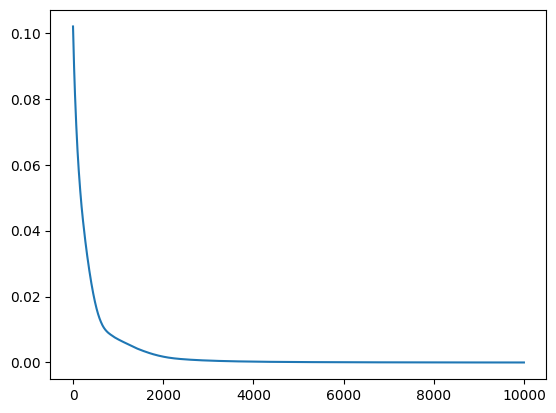

In [7]:
plt.plot(best_model['GRU'][2])

In [8]:
label_y, predicted = predict_mto(best_model['GRU'][1], df, x_ss, y_ms)

4.4402895473885975


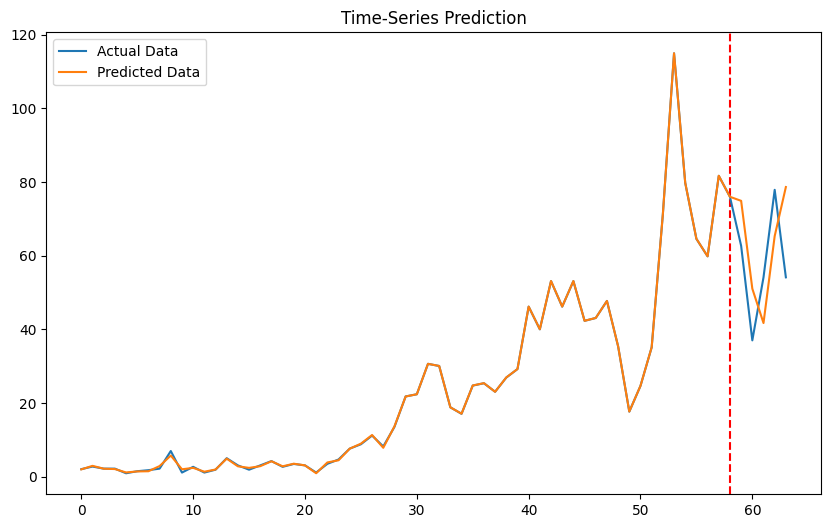

In [9]:
print(rmse(label_y[-7:], predicted[-7:]))
plotting(label_y, predicted, 58)